## Mini-Project - Mandelbrot set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

import time
#%load_ext line_profiler

#### 0. Preps

In [2]:
RE_MIN = -2
RE_MAX = 1
IM_MIN = -1.5
IM_MAX = 1.5

RE_SCALE = 1000
IM_SCALE = 1000

T = 2 # threshold
I = 100 # iteration

In [3]:
re = np.linspace(RE_MIN, RE_MAX, RE_SCALE)
im = np.linspace(IM_MIN, IM_MAX, IM_SCALE) *1j

In [26]:
# for visulalizing the results of algorithms
def plotting(res, title):
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(res, cmap='inferno', extent=[RE_MIN, RE_MAX, IM_MIN, IM_MAX])

In [22]:
# to print out execution time
# func_name : type of algorithm
# m : real axis scale
# n : imaginary axis scale
# dt : execution time

def print_exectime(func_name, m, n, dt):
    print(f"\
    Type: {func_name}\n\
    Axes scale:\n\
        Re: {m}\n\
        Im: {n}\n\
    Execution time : {dt:.4f} [s]")

#### 1. Naive Algorithm

In [9]:
def naive(re_val, im_val, iter, thresh):
    M = np.zeros((re_val.size, im_val.size))
    
    for a in range(re_val.size): 
        for b in range(im_val.size):
            z = 0 + 0j
            c = re_val[a] + im_val[b]

            for i in range(iter):
                z = z**2 + c
            
                if abs(z) > thresh:
                    M[b, a] = i
                    break
            else:
                M[b, a] = iter

    return M

In [23]:
t0 = time.time()
M_naive = naive(re, im, I, T)
dt = time.time() - t0

print_exectime("Naive", RE_SCALE, IM_SCALE, dt)

    Type: Naive
    Axes scale:
        Re: 1000
        Im: 1000
    Execution time : 16.8882 [s]


In [24]:
%timeit naive(re, im, I, T)

25.4 s ± 7.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


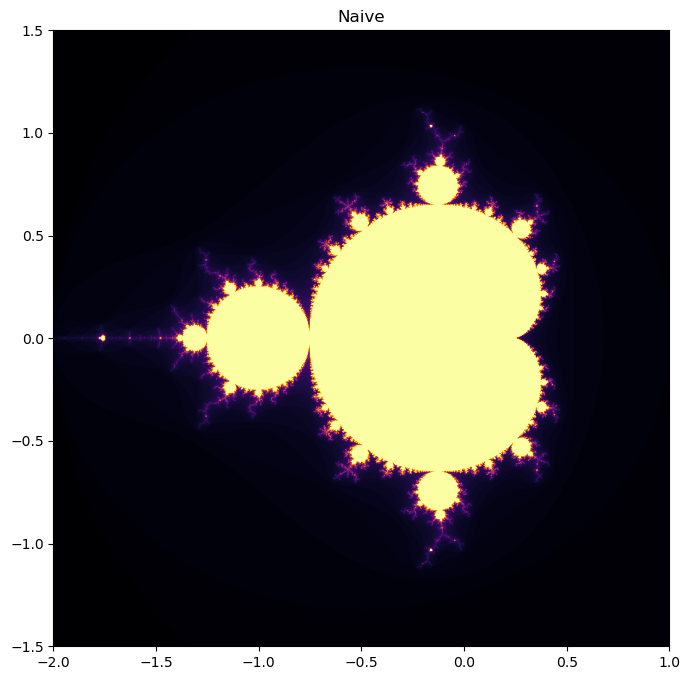

In [27]:
# visualize the result of Naive algorithm
plotting(M_naive, "Naive")

#### 2. Numpy Vectorized Algorithm

Instead of looping over every element, use Numpy vectorized operations.

In [30]:
def vectorized(re_val, im_val, iter, thresh):
    M = np.zeros((re_val.size, im_val.size))
    z = np.zeros((re_val.size, im_val.size), dtype=complex)
    c = re_val + im_val[:, np.newaxis]

    for i in range(iter):
        z = z**2 + c
        M[thresh <= abs(z)] = i

    M[M == 0] = iter

    return M

In [31]:
t0_vec = time.time()
M_vec = vectorized(re, im, I, T)
dt_vec = time.time() - t0_vec

print_exectime("Vectorized", RE_SCALE, IM_SCALE, dt_vec)

    Type: Vectorized
    Axes scale:
        Re: 1000
        Im: 1000
    Execution time : 3.9147 [s]


In [32]:
%timeit vectorized(re, im, I, T)

4.42 s ± 352 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


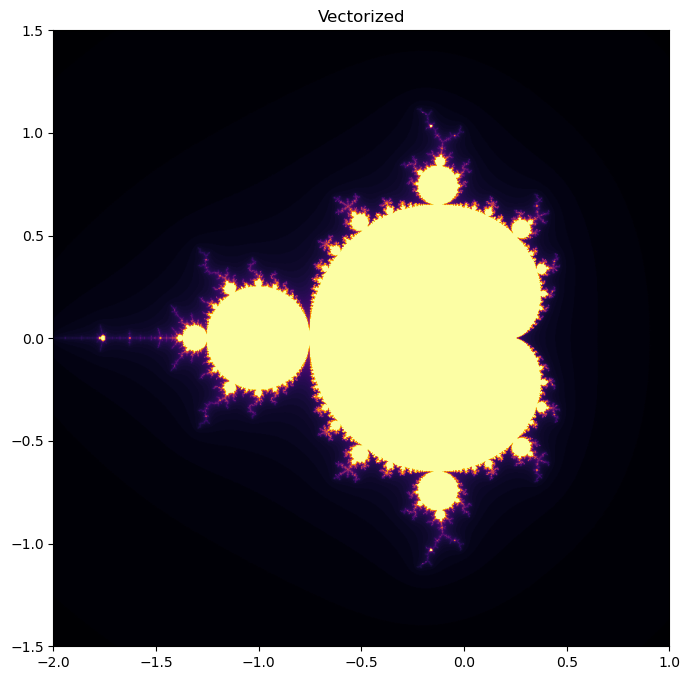

In [33]:
plotting(M_vec, "Vectorized")

#### 3. Numba Optimized

In [34]:
@jit(nopython=True)
def naive_numba(re_val, im_val, iter, thresh):
    M = np.zeros((re_val.size, im_val.size))

    for a in range(re_val.size): 
        for b in range(im_val.size):
            z = 0 + 0j
            c = re_val[a] + im_val[b]

            for i in range(iter):
                z = z**2 + c
            
                if abs(z) > thresh:
                    M[b, a] = i
                    break
            else:
                M[b, a] = iter

    return M

In [35]:
t0_numba = time.time()
M_numba = naive_numba(re, im, I, T)
dt_numba = time.time() - t0_numba

print_exectime("Numba", RE_SCALE, IM_SCALE, dt_numba)

    Type: Numba
    Axes scale:
        Re: 1000
        Im: 1000
    Execution time : 2.8939 [s]


In [36]:
%timeit naive_numba(re, im, I, T)

214 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


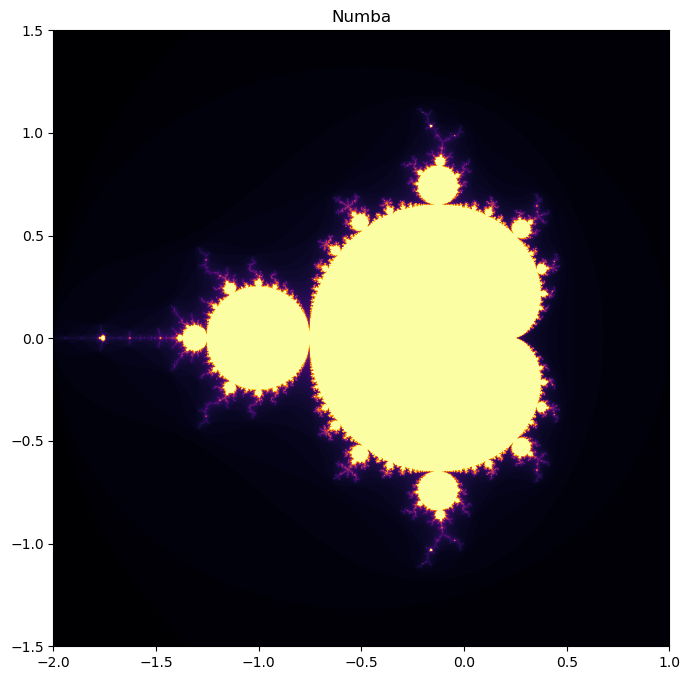

In [37]:
plotting(M_numba, "Numba")

#### 4. Parallel Computing

In [38]:
import pandas as pd
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing as mp
import parallel_mandelbrot as pmb 
# to parallelize in Jupyter Notebook, the task function must be in an outside .py file

Analyzing performance

In [126]:
CHUNK_SIZE = 100
PROC_NUM  = [num for num in range(1, mp.cpu_count() + 1)]

In [54]:
df = pd.DataFrame(columns=['proc_num', 'chunks', 'time'])

comp_matrix = re + im[:, np.newaxis]
items = [(C, I, T) for C in comp_matrix]


for proc_num in PROC_NUM: 
    for chunk in range(1, CHUNK_SIZE):
        t0 = time.time()
    
        pool = mp.Pool(processes=proc_num)
        res = [pool.starmap(pmb.parallel_mb, items, chunksize=chunk)]
    
        pool.close()
        pool.join()

        new_row = pd.Series({'proc_num' : proc_num, \
                            'chunks' : chunk, \
                            'time': time.time() - t0})
        
        df = pd.concat([df, new_row.to_frame().T], ignore_index=True)


#end = [r.get() for r in res]

Visualizing performances

In [124]:
FILEPATH = 'output.csv'
df = pd.read_csv(FILEPATH)

In [174]:
def get_speedup(df, chunk_nums):
    df_new = pd.DataFrame() # this will return 

    
    # iterate through CHUNK_NUMS
    for chunk in range(1, chunk_nums):
        df_temp = df.copy() # for the different size of chunks
        
        # filtering the chunksize to get one [proc_num = 1] time value 
        df_temp = df_temp[df_temp['chunks'] == chunk]

        proc1_time = []
        # get the time for proc_num == 1, and create a list 
        for i in range(len(df_temp.index)):
            proc1_time.append(df_temp[df_temp['proc_num'] == 1]['time'].item())

        # add list as a new column ['proc1_time']
        df_temp['proc1_time'] = proc1_time
        df_new = pd.concat([df_new, df_temp], ignore_index=True) # append rows to the new dataframe
    
    # create speedup col -> divide proc1_time / time
    df_new['speedup'] = df_new['proc1_time'] / df_new['time']
    df_new = df_new.drop(columns='proc1_time')

    # return dataframe with speedup column
    return df_new

In [181]:
df = get_speedup(df, CHUNK_SIZE)

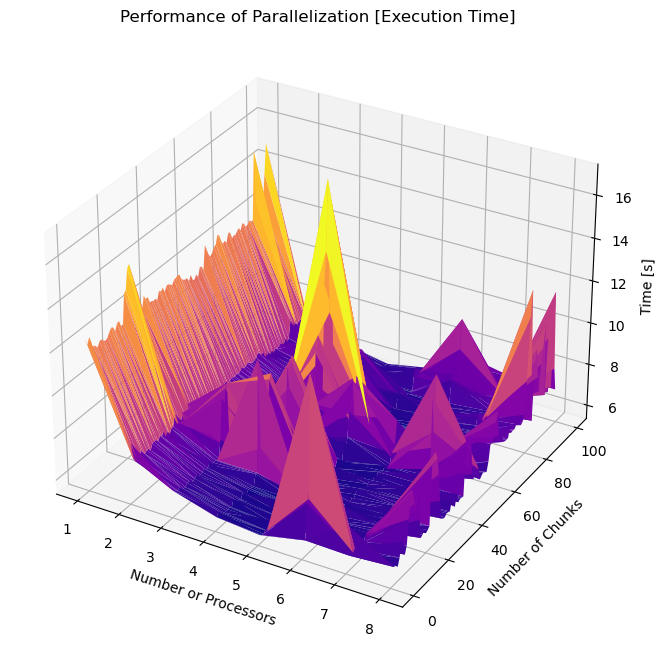

In [191]:
x = df['proc_num']
y = df['chunks']
z = df['time']

plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, cmap='plasma')

ax.set_xlabel('Number or Processors')
ax.set_ylabel('Number of Chunks')
ax.set_zlabel('Time [s]')
ax.set_title('Performance of Parallelization [Execution Time]')

plt.show()

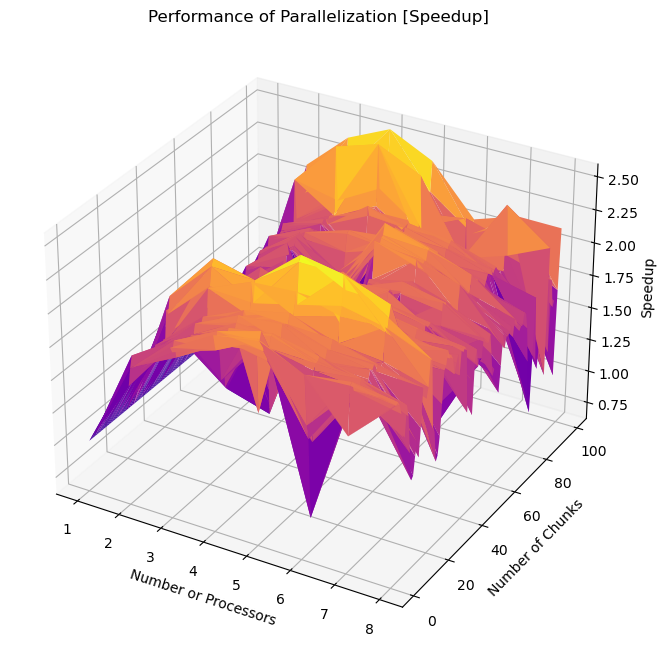

In [189]:
x = df['proc_num']
y = df['chunks']
z = df['speedup']

plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, cmap='plasma')

ax.set_xlabel('Number or Processors')
ax.set_ylabel('Number of Chunks')
ax.set_zlabel('Speedup')
ax.set_title('Performance of Parallelization [Speedup]')

plt.show()

In [182]:
# data of shortest execution time
df[df['time'] == min(df['time'])]

,proc_num,chunks,time,speedup
156,5.0,20.0,5.583213,2.105586


In [192]:
BEST_PROC_NUM = 5
BEST_CHUNKS_NUM = 20

In [187]:
# data with biggest speedup
df[df['speedup'] == max(df['speedup'])]

,proc_num,chunks,time,speedup
787,4.0,99.0,5.876955,2.553988


In [63]:
# to save data from iteration, not to iterate through again
from pathlib import Path  

filepath = Path('output.csv')
filepath.parent.mkdir(parents=True, exist_ok=True) 
df.to_csv(filepath, index=False)

Parallelize with Best Performance

In [229]:
def parallelize(func, proc_num, chunk_num, re_scale, im_scale, iter, thresh):
    comp_matrix = re_scale + im_scale[:, np.newaxis]
    items = [(C, iter, thresh) for C in comp_matrix]
    pool = mp.Pool(processes=proc_num)
    output = [pool.starmap(func, items, chunksize=chunk_num)]
    
    pool.close()
    pool.join()
    
    return output

In [236]:
t0_parallel = time.time()
M_parallel = parallelize(pmb.parallel_mb, BEST_PROC_NUM, BEST_CHUNKS_NUM, re, im, I, T)
dt_parallel = time.time() - t0_parallel

print_exectime("Parallelized", RE_SCALE, IM_SCALE, dt_parallel)

    Type: Parallelized
    Axes scale:
        Re: 1000
        Im: 1000
    Execution time : 5.0899 [s]


In [235]:
%timeit parallelize(pmb.parallel_mb, BEST_PROC_NUM, BEST_CHUNKS_NUM, re, im, I, T)

6.12 s ± 1.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


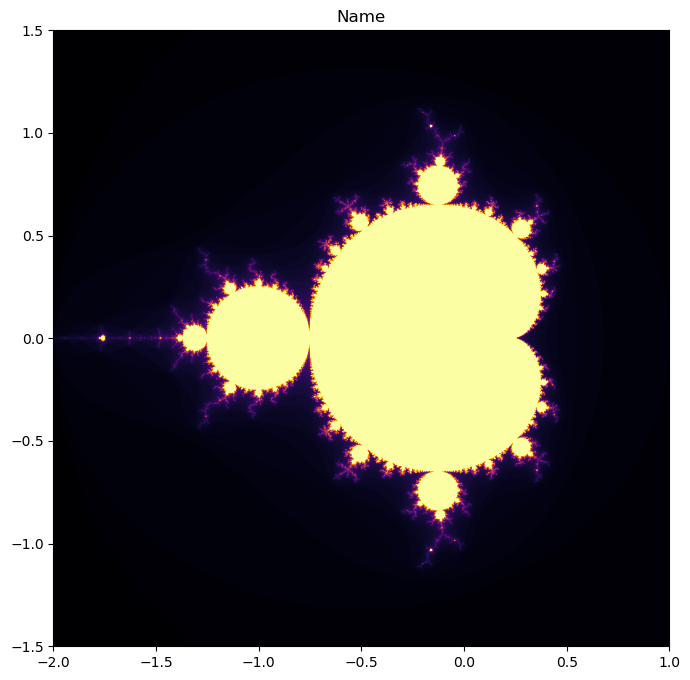

In [225]:
plotting(M_parallel[0], "Parallelized")